# Classification Modeling

Our objective is to identify the classification model that best predicts the primary cause of failure, `c78`, with respect to several evaluation metrics.

The final performance for each model is given below.

**Dummy Classifier**\
Precision Macro: 0.0027+0.0000\
Recall Macro: 0.0200+0.0000\
F1 Macro: 0.0047+0.0000\
F1 Micro: 0.1326+0.0000


**Naive Bayes**\
Precision Macro: 0.0027+0.0000\
Recall Macro: 0.0200+0.0000\
F1 Macro: 0.0047+0.0000\
F1 Micro: 0.1326+0.0000


**K-Nearest Neighbor**\
Precision Macro: 0.2356+0.0423\
Recall Macro: 0.1337+0.0067\
F1 Macro: 0.1306+0.0092\
F1 Micro: 0.3153+0.0098


**Decision Tree**\
Precision Macro: 0.3611+0.0058\
Recall Macro: 0.3611+0.0058\
F1 Macro: 0.1230+0.0067\
F1 Micro: 0.3611+0.0058


**SVM**\
Precision Macro: 0.0453+0.0150\
Recall Macro: 0.0212+0.0021\
F1 Macro: 0.0181+0.0029\
F1 Micro: 0.1487+0.0041

Notes
- I am unsure why the Dummy Classifier deviated from Lindsey's results and is equal to the Naive Bayes. I re-ran Lindsey's notebooks though and got these same values so possibly she completed the Dummy Classifier prior to finalizing `Encoding_Feature.csv`
- The Decison Tree and SVM scores are from an earlier run where I intentionally used a subset of the features and both still took a while to train. I will attempt to fit them again with all the features but it might prove infeasible.

# Feature Selection

In [20]:
#| hide
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

Reading in the `stratified_subset_data.csv`, we see that some of the features are categorical

In [23]:
df=pd.read_csv("../data/cleaned-data/stratified_subset_data.csv",index_col=0)
df.head()

,c144,c23,c24,c25,c27,c13,c102,c106,c41,c49,c50,c52,c53,c56,c59,c78,c80,c96,c109
0,1H71,CESSNA,150D,150,CE,MI,1,B,1,S,59.0,O,214.0,214.0,IN,CH,O,DD,Day
1,1H71,CESSNA,172,172,CE,WA,1,C,1,S,30.0,O,309.0,378.0,WA,SO,V,AA,Day
2,1Q71,WACO,YMF,YMF,EA,RI,1,B,1,S,47.0,O,NaN,NaN,RI,CH,E,DD,Day
3,1L71,PIPER,PA32R301,PA32,SO,VA,1,C,1,S,43.0,O,90.0,267.0,VA,FA,V,BD,Night
4,1G72,BOLKMS,BK117A1,117,EU,FL,5,B,3,S,48.0,O,100.0,4000.0,FL,IO,V,HD,Night


/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


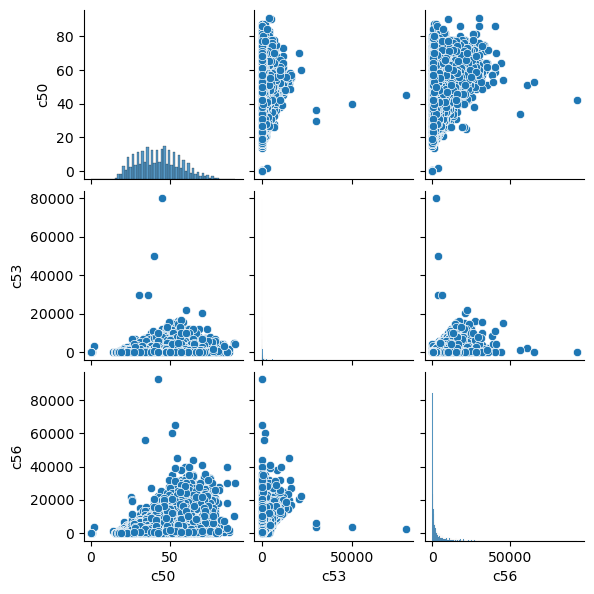

In [24]:
cols = ['c144', 'c23','c24','c52','c78','c109','c13','c27','c106','c49','c59','c80','c96','c41','c102','c25','c50','c53','c56']
plot = sns.pairplot(df[cols], size=2.0)

One option to ensure we can apply all of the models is to use one-hot encoding

In [25]:
df.dtypes

c144     object
c23      object
c24      object
c25      object
c27      object
c13      object
c102     object
c106     object
c41      object
c49      object
c50     float64
c52      object
c53     float64
c56     float64
c59      object
c78      object
c80      object
c96      object
c109     object
dtype: object

Let's bin `c50`, `c53` and `c56`, since they correspond to age of pilot, number of hours pilot as flown in make and model of aircraft, number of hours pilot has flown. We will break each into 10 bins.

In [26]:
bin_cols = ['c50', 'c53', 'c56']
for col in bin_cols:
    df[col] = pd.qcut(df[col], q = 10, labels = [i for i in range(10)])

df[bin_cols]

,c50,c53,c56
0,8,6,2
1,1,7,3
2,6,NaN,NaN
3,5,4,2
4,6,5,7
...,...,...,...
22784,2,4,3
22785,8,5,4
22786,8,6,3
22787,4,5,2


In [27]:
df = df.astype({'c50': object, 'c53': object, 'c56': object})
df.dtypes

c144    object
c23     object
c24     object
c25     object
c27     object
c13     object
c102    object
c106    object
c41     object
c49     object
c50     object
c52     object
c53     object
c56     object
c59     object
c78     object
c80     object
c96     object
c109    object
dtype: object

In [28]:
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
df['c78'] = le.fit_transform(df['c78'])

categorical_cols = df.columns.to_list()
categorical_cols.remove('c78')

#One-hot-encode the categorical columns.

one_hot = pd.get_dummies(df[categorical_cols])

#Concatenate the two dataframes : 
df = pd.concat([one_hot, df['c78']], axis=1)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


We know have one-hot encoded features

In [29]:
df.head()

,c144_1B00,c144_1B71,c144_1B72,c144_1D71,c144_1F71,c144_1G00,c144_1G71,c144_1G72,c144_1H00,c144_1H71,...,c96_KG,c96_PJ,c96_PL,c96_SR,c109_Dawn,c109_Day,c109_Dusk,c109_Night,c109_Unknown,c78
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,2
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,40
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,5
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,20


In [30]:
df.describe()

,c144_1B00,c144_1B71,c144_1B72,c144_1D71,c144_1F71,c144_1G00,c144_1G71,c144_1G72,c144_1H00,c144_1H71,...,c96_KG,c96_PJ,c96_PL,c96_SR,c109_Dawn,c109_Day,c109_Dusk,c109_Night,c109_Unknown,c78
count,21264.000000,21264.000000,21264.000000,21264.000000,21264.000000,21264.000000,21264.000000,21264.000000,21264.000000,21264.000000,...,21264.000000,21264.000000,21264.000000,21264.000000,21264.000000,21264.00000,21264.000000,21264.000000,21264.000000,21264.000000
mean,0.008982,0.000047,0.000047,0.000094,0.000047,0.000094,0.047075,0.002869,0.000047,0.418172,...,0.002916,0.004374,0.000141,0.004044,0.007007,0.82341,0.030004,0.116817,0.003762,21.104919
std,0.094351,0.006858,0.006858,0.009698,0.006858,0.009698,0.211804,0.053485,0.006858,0.493270,...,0.053920,0.065990,0.011877,0.063468,0.083417,0.38133,0.170602,0.321210,0.061223,13.521966
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,11.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,17.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,29.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,49.000000


Let's now export the resulting dataframe to `Encoded_Features.csv`

In [97]:
df.to_csv('../data/cleaned-data/Encoded_Features.csv')

# Dummy Classifier

In [51]:
#| hide
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

First, we will fit a dummy model to act as a baseline.

In [53]:
# Changing the read file location to the location of the file
df = pd.read_csv('../data/cleaned-data/Encoded_Features.csv', index_col=0)

In [67]:
df.shape[0]

21264

In [54]:
# Separating the dependent and independent variable
y = df['c78'] #labels
X = df.drop('c78', axis=1) #features

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size = 0.2)

In [55]:
strategies = ['most_frequent', 'stratified', 'uniform']
  
test_scores = []
for s in strategies:
    if s =='constant':
        dclf = DummyClassifier(strategy = s, random_state = 0, constant ='M')
    else:
        dclf = DummyClassifier(strategy = s, random_state = 0)
        
    dclf.fit(X_train, y_train)
    y_pred = dclf.predict(X_test)    
    score = dclf.score(X_test, y_test)
    test_scores.append(score)
    #print(confusion_matrix(y_test, y_pred))
    #print(classification_report(y_test, y_pred))
    
dclf = DummyClassifier(strategy = 'most_frequent', random_state = 0)
scoring = ['precision_macro', 'recall_macro', 'f1_macro','f1_micro','accuracy']
scores_dclf = cross_validate(dclf, X, y,cv=10, scoring=scoring)
sorted(scores_dclf.keys())

print("%0.4f+%0.4f" % (scores_dclf['test_precision_macro'].mean(), scores_dclf['test_precision_macro'].std()))
print("%0.4f+%0.4f" % (scores_dclf['test_recall_macro'].mean(), scores_dclf['test_recall_macro'].std()))
print("%0.4f+%0.4f" % (scores_dclf['test_f1_macro'].mean(), scores_dclf['test_f1_macro'].std()))
print("%0.4f+%0.4f" % (scores_dclf['test_f1_micro'].mean(), scores_dclf['test_f1_micro'].std()))

0.0027+0.0000
0.0200+0.0000
0.0047+0.0000
0.1326+0.0000


[Text(0.5, 0, 'Dummy Strategy'), Text(0, 0.5, 'Accuracy')]

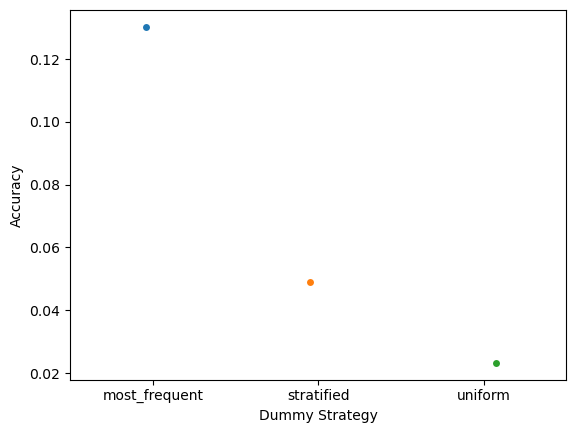

In [56]:
ax = sns.stripplot(strategies, test_scores);
ax.set(xlabel ='Dummy Strategy', ylabel ='Accuracy')

# Naive Bayes

In [98]:
#| hide
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import datasets
from sklearn import naive_bayes

Next, we will try a Naive Bayes model.

In [99]:
# Read dataset to pandas dataframe
irisdata = pd.read_csv('../data/cleaned-data/Encoded_Features.csv', index_col=0)

In [100]:
X = irisdata.drop('c78', axis=1)
y = irisdata['c78']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [102]:
from sklearn.model_selection import GridSearchCV
Naive = naive_bayes.MultinomialNB()

param_grid = {'alpha': [100000, 500000, 1000000]}
#use gridsearch to test all values for n_neighbors
nb_gscv = GridSearchCV(Naive, param_grid, cv=10, verbose=2)
#fit model to data
nb_gscv.fit(X, y)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] END .......................................alpha=100000; total time=  18.0s
[CV] END .......................................alpha=100000; total time=  18.1s
[CV] END .......................................alpha=100000; total time=  18.1s
[CV] END .......................................alpha=100000; total time=  18.1s
[CV] END .......................................alpha=100000; total time=  18.1s
[CV] END .......................................alpha=100000; total time=  18.1s
[CV] END .......................................alpha=100000; total time=  18.9s
[CV] END .......................................alpha=100000; total time=  18.1s
[CV] END .......................................alpha=100000; total time=  18.0s
[CV] END .......................................alpha=100000; total time=  28.4s
[CV] END .......................................alpha=500000; total time=  18.5s
[CV] END .......................................

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': [100000, 500000, 1000000]}, verbose=2)

In [103]:
nb_gscv.best_params_

{'alpha': 100000}

In [104]:
Naive = naive_bayes.MultinomialNB(alpha=1000000)
Naive.fit(X_train,y_train)# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test)# Use accuracy_score function to get the accuracy

In [106]:
scoring = ['precision_macro', 'recall_macro', 'f1_macro','f1_micro','accuracy']
scores_nb = cross_validate(Naive, X, y, cv=10, scoring = scoring, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  29.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.5s remaining:    0.0s


[CV] END .................................................... total time=  29.4s
[CV] END .................................................... total time=  29.1s
[CV] END .................................................... total time=  29.8s
[CV] END .................................................... total time=  30.5s
[CV] END .................................................... total time=  27.3s
[CV] END .................................................... total time=  28.6s
[CV] END .................................................... total time=  28.4s
[CV] END .................................................... total time=  28.1s
[CV] END .................................................... total time=  28.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.8min finished


In [107]:
sorted(scores_nb.keys())
scores_nb

{'fit_time': array([29.40935636, 29.29487848, 29.02299118, 29.67805696, 30.41820049,
        27.21647263, 28.4566586 , 28.28060436, 27.96033669, 27.95482945]),
 'score_time': array([0.12052965, 0.11404657, 0.1136179 , 0.11438704, 0.11736965,
        0.11576581, 0.11674356, 0.11988378, 0.11960602, 0.11597013]),
 'test_precision_macro': array([0.00265162, 0.00265162, 0.00265162, 0.00265162, 0.00265287,
        0.00265287, 0.00265287, 0.00265287, 0.00265287, 0.00265287]),
 'test_recall_macro': array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]),
 'test_f1_macro': array([0.00468244, 0.00468244, 0.00468244, 0.00468244, 0.00468439,
        0.00468439, 0.00468439, 0.00468439, 0.00468439, 0.00468439]),
 'test_f1_micro': array([0.1325811 , 0.1325811 , 0.1325811 , 0.1325811 , 0.13264346,
        0.13264346, 0.13264346, 0.13264346, 0.13264346, 0.13264346]),
 'test_accuracy': array([0.1325811 , 0.1325811 , 0.1325811 , 0.1325811 , 0.13264346,
        0.13264346, 0.13264346, 0.132643

In [108]:
print("%0.4f+%0.4f" % (scores_nb['test_precision_macro'].mean(), scores_nb['test_precision_macro'].std()))
print("%0.4f+%0.4f" % (scores_nb['test_recall_macro'].mean(), scores_nb['test_recall_macro'].std()))
print("%0.4f+%0.4f" % (scores_nb['test_f1_macro'].mean(), scores_nb['test_f1_macro'].std()))
print("%0.4f+%0.4f" % (scores_nb['test_f1_micro'].mean(), scores_nb['test_f1_micro'].std()))

0.0027+0.0000
0.0200+0.0000
0.0047+0.0000
0.1326+0.0000


# K - Nearest Neighhbor

In [2]:
#| hide
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Import the 3 dimensionality reduction methods
from sklearn.decomposition import PCA

In [4]:
data = pd.read_csv('../data/cleaned-data/Encoded_Features.csv',index_col=0)
data.head()

X = data.drop('c78', axis=1)
y = data['c78']
    
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size = 0.2)


In [112]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
knn.score(X_test,y_test)

0.29579120620738303

In [113]:
from sklearn.model_selection import cross_val_score
import numpy as np
#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=3)
#train model with cv of 10 
cv_scores = cross_val_score(knn_cv, X, y, cv=10)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.23883404 0.22708039 0.24494593 0.23601316 0.23941675 0.23800564
 0.23565381 0.23330198 0.22483537 0.23377234]
cv_scores mean:0.2351859419787961


In [114]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 100)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=10, verbose=10)
#fit model to data
knn_gscv.fit(X, y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV 1/10; 1/99] START n_neighbors=1.............................................
[CV 1/10; 1/99] END ..............n_neighbors=1;, score=0.223 total time=   3.8s
[CV 2/10; 1/99] START n_neighbors=1.............................................
[CV 2/10; 1/99] END ..............n_neighbors=1;, score=0.200 total time=   3.7s
[CV 3/10; 1/99] START n_neighbors=1.............................................
[CV 3/10; 1/99] END ..............n_neighbors=1;, score=0.217 total time=   3.7s
[CV 4/10; 1/99] START n_neighbors=1.............................................
[CV 4/10; 1/99] END ..............n_neighbors=1;, score=0.217 total time=   3.7s
[CV 5/10; 1/99] START n_neighbors=1.............................................
[CV 5/10; 1/99] END ..............n_neighbors=1;, score=0.210 total time=   3.7s
[CV 6/10; 1/99] START n_neighbors=1.............................................
[CV 6/10; 1/99] END ..............n_neighbors=

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             verbose=10)

In [115]:
knn_gscv.best_params_
#knn_gscv.best_score_

{'n_neighbors': 45}

In [116]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
import numpy as np
#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=45)
#train model with cv of 10 

In [117]:
scoring = ['precision_macro', 'recall_macro', 'f1_macro','f1_micro','accuracy']
scores_knn = cross_validate(knn_cv, X, y, cv=10, scoring = scoring)
#print each cv score (accuracy) and average them
sorted(scores_knn.keys())
scores_knn

{'fit_time': array([0.85636282, 0.49874997, 0.5051713 , 0.48534489, 0.4949882 ,
        0.49622059, 0.49663901, 0.48606586, 0.49530411, 0.47655201]),
 'score_time': array([1.98693371, 2.40405393, 2.93795228, 2.62931323, 2.09334898,
        2.16602802, 2.09480214, 2.35734534, 2.1879952 , 2.37793231]),
 'test_precision_macro': array([0.19997276, 0.31106627, 0.26910541, 0.21671609, 0.20075895,
        0.26377379, 0.15877166, 0.26623614, 0.25203867, 0.21710113]),
 'test_recall_macro': array([0.12133596, 0.1473856 , 0.13502954, 0.13275619, 0.13448904,
        0.12994185, 0.12763656, 0.14093678, 0.13240046, 0.13547305]),
 'test_f1_macro': array([0.11585435, 0.15030466, 0.13415572, 0.12612722, 0.13056661,
        0.12777295, 0.12000804, 0.13946819, 0.12962251, 0.13253774]),
 'test_f1_micro': array([0.29384109, 0.32769158, 0.32346027, 0.31076634, 0.31608655,
        0.31984948, 0.31420508, 0.31420508, 0.30573848, 0.32690499]),
 'test_accuracy': array([0.29384109, 0.32769158, 0.32346027, 0.3107

In [118]:
print("%0.4f+%0.4f" % (scores_knn['test_accuracy'].mean(), scores_knn['test_accuracy'].std()))
print("%0.4f+%0.4f" % (scores_knn['test_precision_macro'].mean(), scores_knn['test_precision_macro'].std()))
print("%0.4f+%0.4f" % (scores_knn['test_recall_macro'].mean(), scores_knn['test_recall_macro'].std()))
print("%0.4f+%0.4f" % (scores_knn['test_f1_macro'].mean(), scores_knn['test_f1_macro'].std()))
print("%0.4f+%0.4f" % (scores_knn['test_f1_micro'].mean(), scores_knn['test_f1_micro'].std()))

0.3153+0.0098
0.2356+0.0423
0.1337+0.0067
0.1306+0.0092
0.3153+0.0098


In [5]:
import matplotlib.pyplot as plt 
error_rate = []
from sklearn.neighbors import KNeighborsClassifier

for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    error_rate.append(np.mean(pred != y_test))

In [9]:
#Best -> k = 31 -> err_rate = 0.6762285445567835
error_rate.index(min(error_rate))
error_rate[30]

0.6762285445567835

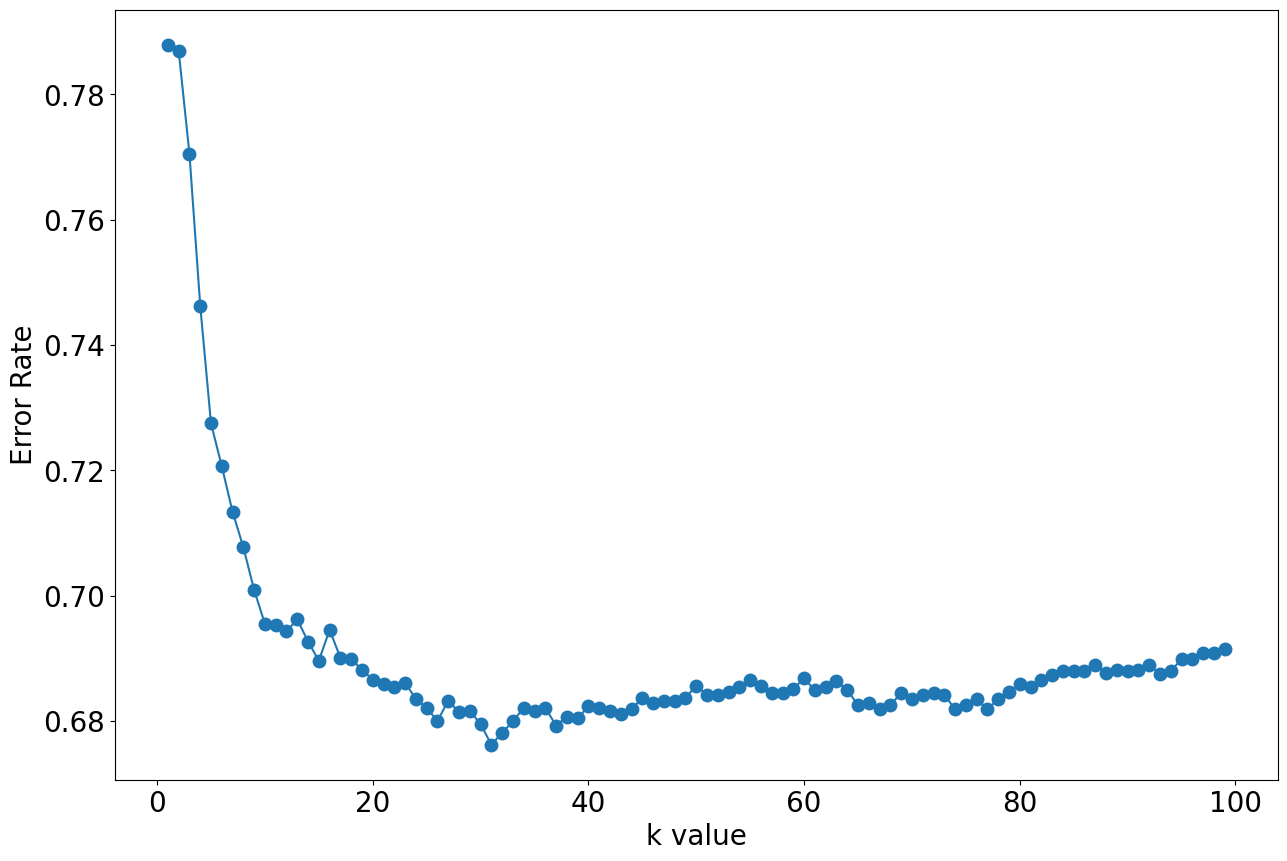

In [10]:
fig = plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20})
plt.xlabel("k value")
plt.ylabel("Error Rate")
plt.plot(range(1,100),error_rate, marker='o', markersize=9)

# Decision Tree

In [148]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [149]:
dataset = pd.read_csv('../data/cleaned-data/Encoded_Features.csv',index_col=0) 
dataset

,c144,c23,c24,c25,c27,c13,c102,c106,c41,c49,c50,c52,c53,c56,c59,c78,c80,c96,c109
0,10,127,705,145,24,19,0,1,1,4,7,1,5,230,21,32,30,31,1
1,10,264,1763,607,19,54,0,1,3,4,41,6,135,2882,12,94,33,21,1
2,10,315,934,241,9,0,0,1,1,4,11,12,145,335,0,103,8,40,1
3,10,264,1752,606,5,0,0,0,3,2,31,9,1256,3044,0,40,30,7,1
4,16,128,920,167,4,81,0,1,5,2,25,12,490,3439,19,4,30,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22784,15,23,1488,483,9,10,0,2,1,8,44,13,0,691,12,54,30,30,1
22785,15,264,1840,619,5,10,3,2,3,8,32,13,200,496,12,54,30,30,3
22786,7,207,255,75,29,10,4,1,8,8,24,9,1360,2211,12,40,30,19,1
22787,10,148,69,34,4,50,0,1,1,8,14,13,145,190,7,75,12,16,1


In [150]:
from sklearn.model_selection import train_test_split
X = dataset.copy().drop(columns=['c78'])
y = dataset['c78']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [151]:
targets = dataset['c78'].unique().tolist()
targets = [str(x) for x in targets]

In [152]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dTree = DecisionTreeClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'max_depth': np.arange(1, 100)}
#use gridsearch to test all values for n_neighbors
dTree_gscv = GridSearchCV(dTree, param_grid, cv=10, verbose=2)
#fit model to data
dTree_gscv.fit(X, y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END .....................................

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             verbose=2)

In [153]:
dTree_gscv.best_params_

{'max_depth': 10}

In [154]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import numpy as np
#create a new KNN model
dTree = DecisionTreeClassifier(max_depth = 10)

In [154]:
#train model with cv of 10 
scoring = ['precision_macro', 'recall_acro', 'f1_macro','f1_micro','accuracy']
scores_dt = cross_validate(dTree, X, y, cv=10, scoring = scoring)
#print each cv score (accuracy) and average them
sorted(scores_dt.keys())
print("%0.4f+%0.4f" % (scores_dt['test_precision_macro'].mean(), scores_dt['test_precision_macro'].std()))
print("%0.4f+%0.4f" % (scores_dt['test_recall_macro'].mean(), scores_dt['test_recall_macro'].std()))
print("%0.4f+%0.4f" % (scores_dt['test_f1_macro'].mean(), scores_dt['test_f1_macro'].std()))
print("%0.4f+%0.4f" % (scores_dt['test_f1_micro'].mean(), scores_dt['test_f1_micro'].std()))

0.3611+0.0058
0.3611+0.0058
0.1230+0.0067
0.3611+0.0058


In [ ]:
dTree = DecisionTreeClassifier(max_depth = 10)
dTree.fit(X,y)
fig = plt.figure(figsize=(70,30))
_ = tree.plot_tree(dTree, 
                   feature_names=dataset.columns,  
                   class_names=targets,
                   filled=True,fontsize=20)
plt.show()

In [156]:
text_representation = tree.export_text(dTree)
print(text_representation)

|--- feature_16 <= 30.50
|   |--- feature_16 <= 29.50
|   |   |--- feature_16 <= 16.50
|   |   |   |--- feature_15 <= 12.50
|   |   |   |   |--- feature_15 <= 10.50
|   |   |   |   |   |--- feature_9 <= 3.50
|   |   |   |   |   |   |--- feature_13 <= 955.50
|   |   |   |   |   |   |   |--- feature_10 <= 41.50
|   |   |   |   |   |   |   |   |--- class: 69
|   |   |   |   |   |   |   |--- feature_10 >  41.50
|   |   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |--- feature_13 >  955.50
|   |   |   |   |   |   |   |--- feature_15 <= 8.50
|   |   |   |   |   |   |   |   |--- feature_1 <= 160.50
|   |   |   |   |   |   |   |   |   |--- feature_9 <= 2.50
|   |   |   |   |   |   |   |   |   |   |--- class: 49
|   |   |   |   |   |   |   |   |   |--- feature_9 >  2.50
|   |   |   |   |   |   |   |   |   |   |--- class: 69
|   |   |   |   |   |   |   |   |--- feature_1 >  160.50
|   |   |   |   |   |   |   |   |   |--- class: 31
|   |   |   |   |   |   |   |--- feature_15 >  8

# SVM

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import datasets
from sklearn.svm import SVC

In [2]:
# Assign colum names to the dataset
colnames = ['c144','c23','c24','c25','c27','c13','c102','c106','c41','c49', 'c50', 'c52', 'c80', 'c96', 'c109','c78']

# Read dataset to pandas dataframe
irisdata = pd.read_csv('../data/cleaned-data/Encoded_Features.csv',usecols=colnames)

In [3]:
X = irisdata.drop('c78', axis=1)
y = irisdata['c78']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [5]:
clf = SVC(kernel = 'poly', degree = 8)
#clf.fit(X_train, y_train)
scoring = ['precision_macro', 'recall_macro', 'f1_macro','f1_micro','accuracy']
scores_res = cross_validate(clf, X, y, cv=10, scoring = scoring)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [ ]:
from sklearn.model_selection import GridSearchCV
clf = SVC(kernel = 'poly', degree = 2)

param_grid = {'degree': [2, 4, 10]}
#use gridsearch to test all values for n_neighbors
svm_gscv = GridSearchCV(clf, param_grid, cv=2)
#fit model to data
svm_gscv.fit(X, y)

In [7]:
sorted(scores_res.keys())
scores_res

{'fit_time': array([1889.22326255, 3645.23735523, 1848.76933146, 1988.86997342,
        1838.83641362, 1711.68622732, 1769.97253346, 1729.35280895,
        1772.21598983, 1696.40208578]),
 'score_time': array([11.10421562, 47.5643127 , 11.43277121, 12.20550013, 12.46886802,
        12.16364694, 11.61115575, 11.66941142, 11.45319939, 12.55381179]),
 'test_precision_macro': array([0.03526325, 0.04824987, 0.08318548, 0.04999466, 0.05392378,
        0.03490309, 0.03320958, 0.04777263, 0.03851724, 0.02794099]),
 'test_recall_macro': array([0.02224964, 0.02135871, 0.02413596, 0.0240558 , 0.01957375,
        0.01787839, 0.01932417, 0.01948561, 0.0238185 , 0.02029652]),
 'test_f1_macro': array([0.01864003, 0.0190541 , 0.0225871 , 0.02192672, 0.01617443,
        0.01367981, 0.01549697, 0.01593496, 0.02125461, 0.0162016 ]),
 'test_f1_micro': array([0.14918824, 0.14962703, 0.15313734, 0.15577007, 0.14655551,
        0.14216762, 0.14787187, 0.15050461, 0.15006582, 0.14223003]),
 'test_accuracy': a

In [8]:
print("%0.4f+%0.4f" % (scores_res['test_accuracy'].mean(), scores_res['test_accuracy'].std()))
print("%0.4f+%0.4f" % (scores_res['test_precision_macro'].mean(), scores_res['test_precision_macro'].std()))
print("%0.4f+%0.4f" % (scores_res['test_recall_macro'].mean(), scores_res['test_recall_macro'].std()))
print("%0.4f+%0.4f" % (scores_res['test_f1_macro'].mean(), scores_res['test_f1_macro'].std()))
print("%0.4f+%0.4f" % (scores_res['test_f1_micro'].mean(), scores_res['test_f1_micro'].std()))

0.1487+0.0041
0.0453+0.0150
0.0212+0.0021
0.0181+0.0029
0.1487+0.0041


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))